# 根据输入的事件数据计算光流
- 接收不断传入的事件数据，放在暂存区，每400万数据为一个块，来不及处理的块仍在暂存区
- 按照事件数量构造体素网格，并按照事件数量分段，并且每小段之间有事件重叠，不用时间归一化分段，避免体素网格初始或结束通道效果差
- 使用ilk计算体素网格内相邻通道之间的光流，未计算前一个体素网格末尾和后一个体素网格开始的光流，效果较差

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from flow import FlowManager
from event_loader import config, EventManager

# 可视化
from visualizer import plot_events_3d,plot_event_time2d,save_voxel_grid_video, plot_flow_field

from Wind_Tunnel import EventProcessingPipeline

Figure saved to output/event3d.png


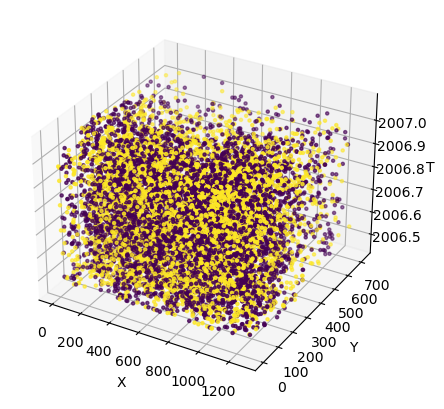

In [3]:
# Test 3， 读取evk5数据
path = "./data/evk5_fengd.hdf5"
event_loader = EventManager(source_type="evk5", path=path, cfg=None, flow_func=None)
evts, _ = event_loader.load()
# print(np.max(evts[:,1]))

# show_events(evts)
plot_events_3d(evts, output_file="output/event3d.png", startN=-10000, endN=-1)
# plot_event_time2d(evts-50000:,:], output_file="output/event2d_3.png", vmin=None, vmax=None)
# save_voxel_grid_video(evts, output_file="output/loader_voxelgrids_3.mp4", img_size=(1280,720), fps=10)

In [21]:
# 初始化
pipeline = EventProcessingPipeline(
    event_chunk_size=4_000_000,
    voxel_params={'num_bins': 6, 'height': 720, 'width': 1280, 'overlap':0.3},
    flow_params={'resize_factor': 2, 'max_workers': 4, 'radius': 20, 'num_warp': 1, 'ksize': (7, 7)},
    device='cuda'
)

# 使用当前事件文件数据，模拟实时输入：每次送入一批事件
batch_size = 1_000_000
num_events = evts.shape[0]
flows = []

for start in range(0, num_events, batch_size):
    end = min(start + batch_size, num_events)
    batch = evts[start:end]

    # 自动结构化 + 处理 + 内部打印
    flow_tensor = pipeline.process_events(batch)
    # 如果这批触发了光流输出，则保存
    if flow_tensor is not None:
        flows.append(flow_tensor.cpu())  # 如已在 CPU 可省略 .cpu()

# 最终拼接所有光流帧，从full_flow依次读取
if flows:
    full_flow = torch.cat(flows, dim=0)  # shape = (N, 2, H, W)
    print(f"\n✅ 总共生成光流帧数: {full_flow.shape[0]}")
else:
    print("⚠️ 未生成任何光流帧")

[进度] 已处理事件: 4000000 | 体素块: 1 | 光流帧: 7 | 平均帧率: 38.08 fps
[进度] 已处理事件: 8000000 | 体素块: 2 | 光流帧: 14 | 平均帧率: 39.20 fps
[进度] 已处理事件: 12000000 | 体素块: 3 | 光流帧: 21 | 平均帧率: 38.89 fps
[进度] 已处理事件: 16000000 | 体素块: 4 | 光流帧: 28 | 平均帧率: 38.97 fps
[进度] 已处理事件: 20000000 | 体素块: 5 | 光流帧: 35 | 平均帧率: 39.13 fps
[进度] 已处理事件: 24000000 | 体素块: 6 | 光流帧: 42 | 平均帧率: 38.95 fps
[进度] 已处理事件: 28000000 | 体素块: 7 | 光流帧: 49 | 平均帧率: 39.08 fps
[进度] 已处理事件: 32000000 | 体素块: 8 | 光流帧: 56 | 平均帧率: 39.22 fps
[进度] 已处理事件: 36000000 | 体素块: 9 | 光流帧: 63 | 平均帧率: 39.32 fps

✅ 总共生成光流帧数: 63


torch.Size([63, 2, 720, 1280])


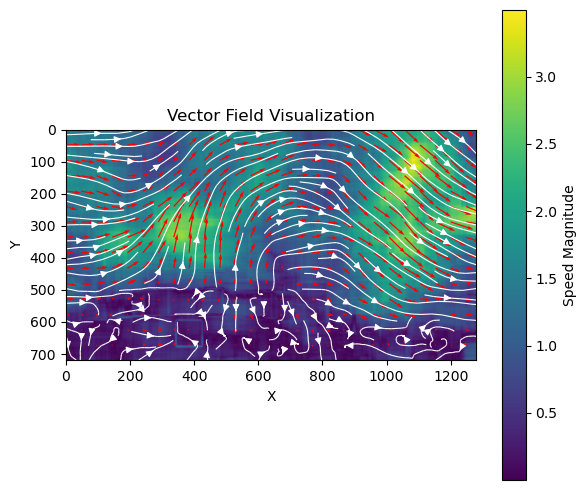

In [22]:
print(full_flow.shape)
i = 58
u = full_flow[i, 0]
v = full_flow[i, 1]
plot_flow_field(u, v, slFlag=True,step=1, quiver_step=48)

In [13]:
# 保存视频查看

def plot_flow_field_img(u, v, magFlag=False, slFlag=True, step=1, quiver_step=16):
    """
    跟你的plot_flow_field类似，但不显示图，只返回numpy rgb数组（H, W, 3）
    """
    H, W = u.shape
    x = np.arange(0, H)
    y = np.arange(0, W)
    xx, yy = np.meshgrid(x, y, indexing='ij')

    magnitude = np.sqrt(u**2 + v**2)

    fig, ax = plt.subplots(figsize=(6, 5))
    if magFlag:
        im = ax.imshow(magnitude[::step, ::step], cmap='viridis', origin='lower')
        # plt.colorbar(im, ax=ax, label='Speed Magnitude')
    else:
        im = ax.imshow(np.zeros_like(magnitude[::step, ::step]), cmap='viridis', origin='lower')
        # plt.colorbar(im, ax=ax, label='')

    if slFlag:
        ax.streamplot(yy, xx, v, u, color='white', linewidth=0.8, density=1.0)

    ax.quiver(yy[::quiver_step, ::quiver_step],
              xx[::quiver_step, ::quiver_step],
              v[::quiver_step, ::quiver_step],
              -u[::quiver_step, ::quiver_step],
              color='red', scale=None)

    ax.set_title("Vector Field Visualization")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xlim([-0.1, W+0.1])
    ax.set_ylim([-0.1, H+0.1])
    ax.invert_yaxis()
    plt.tight_layout()

    # 将图像渲染到numpy数组
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)
    return img

def save_flow_video(flow_tensor, filename='flow_video.mp4', fps=15,
                    magFlag=True, slFlag=True, step=1, quiver_step=48):
    """
    flow_tensor: torch.Tensor, shape (T, 2, H, W)
    filename: 保存视频路径
    fps: 视频帧率
    """
    T, _, H, W = flow_tensor.shape

    # 生成第一帧，初始化视频写入器
    first_frame = plot_flow_field_img(flow_tensor[0, 0].cpu().numpy(),
                                      flow_tensor[0, 1].cpu().numpy(),
                                      magFlag, slFlag, step, quiver_step)
    height, width, _ = first_frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # mp4编码
    video_writer = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    for t in range(T):
        u = flow_tensor[t, 0].cpu().numpy()
        v = flow_tensor[t, 1].cpu().numpy()
        frame_img = plot_flow_field_img(u, v, magFlag, slFlag, step, quiver_step)
        # cv2写视频是BGR，需要转为BGR格式
        frame_bgr = cv2.cvtColor(frame_img, cv2.COLOR_RGB2BGR)
        video_writer.write(frame_bgr)

    video_writer.release()
    print(f"视频保存到 {filename}")

# 假设 flow 是 torch.Size([n, 2, 720, 1280]) 的光流张量
save_flow_video(full_flow, filename='optical_flow_result.mp4', fps=15)

视频保存到 optical_flow_result.mp4
